# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Import-lat-long-data-from-google-geocoded-addresses" data-toc-modified-id="Import-lat-long-data-from-google-geocoded-addresses-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import lat-long data from google-geocoded addresses</a></div><div class="lev1 toc-item"><a href="#Get-X-Y-coordinates-from-Pluto" data-toc-modified-id="Get-X-Y-coordinates-from-Pluto-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get X-Y coordinates from Pluto</a></div><div class="lev2 toc-item"><a href="#Missing-locations" data-toc-modified-id="Missing-locations-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Missing locations</a></div><div class="lev2 toc-item"><a href="#Using-google-geocodes-to-fill-in-missing-data" data-toc-modified-id="Using-google-geocodes-to-fill-in-missing-data-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Using google geocodes to fill in missing data</a></div><div class="lev1 toc-item"><a href="#Map-Pluto" data-toc-modified-id="Map-Pluto-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Map Pluto</a></div><div class="lev1 toc-item"><a href="#School-District-Boundaries" data-toc-modified-id="School-District-Boundaries-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>School District Boundaries</a></div><div class="lev1 toc-item"><a href="#Counties" data-toc-modified-id="Counties-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Counties</a></div><div class="lev1 toc-item"><a href="#Attach-school-district-to-each-sale" data-toc-modified-id="Attach-school-district-to-each-sale-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Attach school district to each sale</a></div><div class="lev1 toc-item"><a href="#Borders" data-toc-modified-id="Borders-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Borders</a></div><div class="lev1 toc-item"><a href="#Checking-district-1-data-is-in-district-1" data-toc-modified-id="Checking-district-1-data-is-in-district-1-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Checking district 1 data is in district 1</a></div><div class="lev1 toc-item"><a href="#Grid-for-extrapolation" data-toc-modified-id="Grid-for-extrapolation-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Grid for extrapolation</a></div><div class="lev1 toc-item"><a href="#Data-Export" data-toc-modified-id="Data-Export-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Data Export</a></div>

In [2]:
RAWDATA_DIR = "NYC_data/raw_data"

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# plt.rc("figure", autolayout=True)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 8.0)

In [4]:
EPSG=2263 # projection

In [5]:
import pandas as pd
import geopandas as gpd
plot_dataframe = gpd.plotting.plot_dataframe
import numpy as np
import itertools

In [6]:
import shapely
from shapely.geometry import Point, LineString, MultiLineString, MultiPoint

In [7]:
def readrolling(borough):
    dat = pd.read_csv("%s/2016/rollingsales_%s.csv" % (RAWDATA_DIR, borough), 
        header=4, 
        thousands=",",
        dtype={" SALE PRICE ": np.float64, 
            "LAND SQUARE FEET": np.float64,
            "GROSS SQUARE FEET": np.float64,
            "BLOCK": np.str,
            "ZIP CODE": np.str,
            "LOT": np.str,
            },
        parse_dates=["SALE DATE"],
        infer_datetime_format=True,
        skipinitialspace=True, 
        na_values=["-", "- ", "-   "],
        )
    dat.BOROUGH = borough.title()
    return dat
brooklyn=readrolling("brooklyn")
bronx=readrolling("bronx")
manhattan=readrolling("manhattan")
queens=readrolling("queens")

In [8]:
sales = pd.concat([brooklyn, bronx, manhattan, queens])
for catcol in ["BOROUGH", "BUILDING CLASS CATEGORY", "BUILDING CLASS AT TIME OF SALE", "ZIP CODE", "TAX CLASS AT PRESENT", "NEIGHBORHOOD"]:
    sales[catcol] = pd.Categorical(sales[catcol])
    try:
        sales[catcol].cat.categories = sales[catcol].cat.categories.str.strip()
    except AttributeError:
        pass
sales.ADDRESS=sales.ADDRESS.str.strip()
sales.reset_index(inplace=True, drop=True)
sales.ix[0]

BOROUGH                                           Brooklyn
NEIGHBORHOOD                                    BATH BEACH
BUILDING CLASS CATEGORY           01  ONE FAMILY DWELLINGS
TAX CLASS AT PRESENT                                     1
BLOCK                                                 6360
LOT                                                     13
EASE-MENT                                              NaN
BUILDING CLASS AT PRESENT                               A5
ADDRESS                                 8665 15TH   AVENUE
APARTMENT NUMBER                                       NaN
ZIP CODE                                             11228
RESIDENTIAL UNITS                                        1
COMMERCIAL UNITS                                       NaN
TOTAL UNITS                                              1
LAND SQUARE FEET                                      1547
GROSS SQUARE FEET                                     1428
YEAR BUILT                                            19

# Import lat-long data from google-geocoded addresses

In [9]:
def readgeocoded(borough):
    dat = pd.read_csv("NYC_data/geocoded/rollingsales_%s_geocoded.csv" % borough,
        dtype={"ZIP CODE": str})
    dat["BOROUGH"] = borough.title()
    dat.ADDRESS = dat.ADDRESS.str.strip()
    return dat

In [10]:
geocodes = pd.concat([readgeocoded(borough) for borough in ["brooklyn", "bronx", "manhattan", "queens"]])

In [11]:
sales_geocoded_ggl=pd.merge(sales, geocodes, how="left", 
    left_on=["BOROUGH","ADDRESS", "ZIP CODE"], 
    right_on=["BOROUGH","ADDRESS", "ZIP CODE"])
sales_geocoded_ggl.rename(columns={"SALE PRICE ": "SALE PRICE"}, inplace=True)
sales_geocoded_ggl.dropna(subset=["SALE PRICE"], inplace=True)
sales_geocoded_ggl.shape

(56815, 23)

In [12]:
sales_geocoded_ggl.iloc[0]

BOROUGH                                           Brooklyn
NEIGHBORHOOD                                    BATH BEACH
BUILDING CLASS CATEGORY           01  ONE FAMILY DWELLINGS
TAX CLASS AT PRESENT                                     1
BLOCK                                                 6361
LOT                                                     11
EASE-MENT                                              NaN
BUILDING CLASS AT PRESENT                               A5
ADDRESS                               71 BAY 10TH   STREET
APARTMENT NUMBER                                       NaN
ZIP CODE                                             11228
RESIDENTIAL UNITS                                        1
COMMERCIAL UNITS                                       NaN
TOTAL UNITS                                              1
LAND SQUARE FEET                                      2900
GROSS SQUARE FEET                                     1660
YEAR BUILT                                            19

In [13]:
np.mean(np.isfinite(sales_geocoded_ggl["lat"])) # hopefully close to 1

0.99996479802868965

In [14]:
_sales_geometry = gpd.GeoSeries([Point(xy) for xy in zip(sales_geocoded_ggl.lng, sales_geocoded_ggl.lat)], crs={"proj":"latlong", "datum":"WGS84"})
_sales_geometry=_sales_geometry.to_crs(epsg=EPSG)

sales_geocoded_ggl["XCoord"]=[p.x for p in _sales_geometry]
sales_geocoded_ggl["YCoord"]=[p.y for p in _sales_geometry]

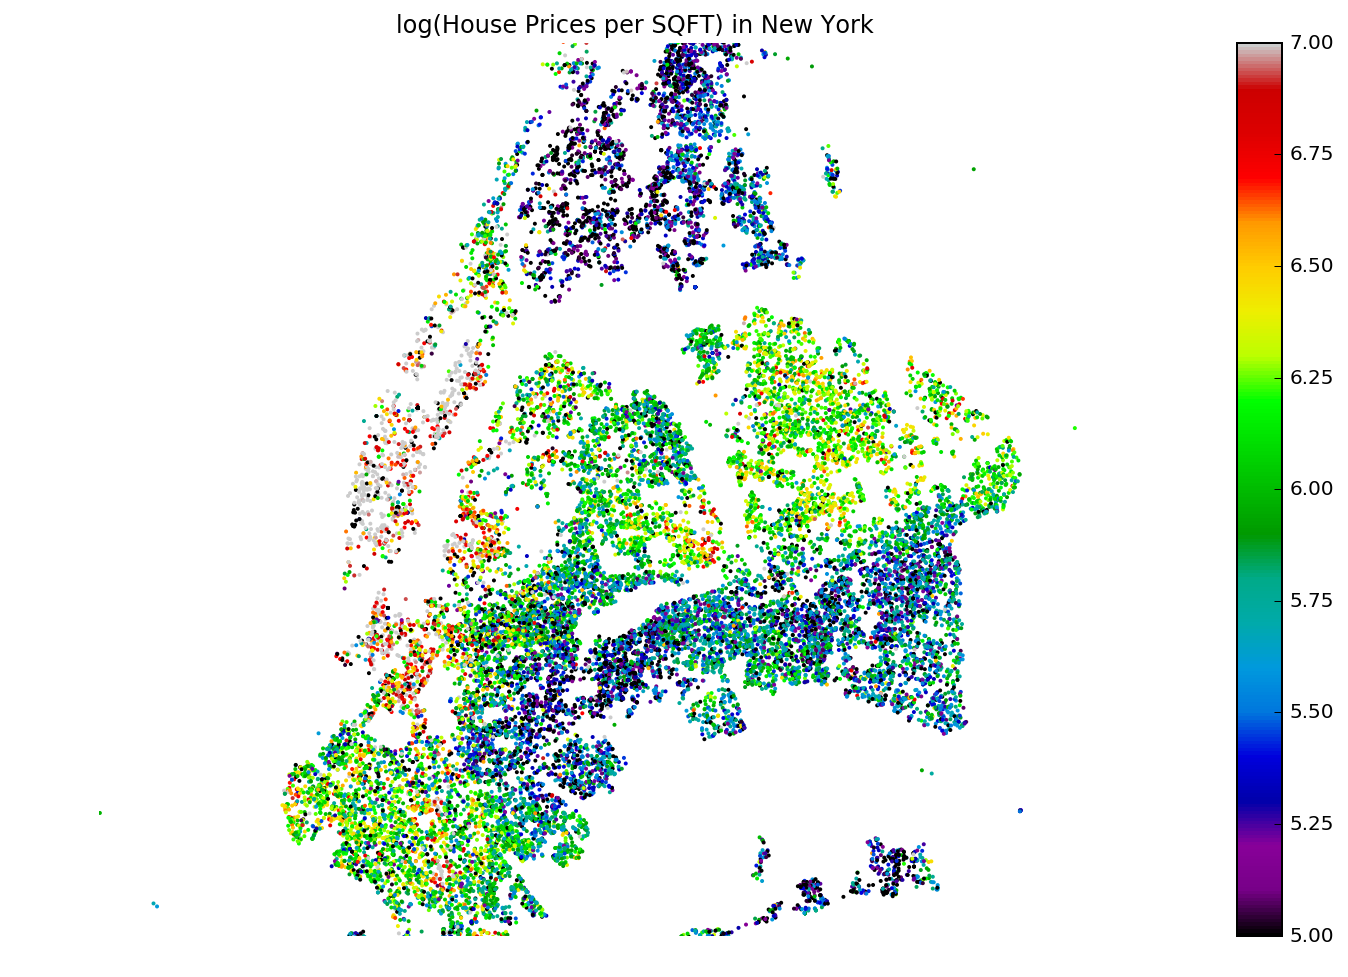

In [15]:
plt.scatter(sales_geocoded_ggl["XCoord"], sales_geocoded_ggl["YCoord"], 
    c=np.log(sales_geocoded_ggl["SALE PRICE"])-np.log(sales_geocoded_ggl["GROSS SQUARE FEET"]),
    cmap="spectral",
    edgecolor="None",
    vmin=5.0,
    vmax=7.0,
    s=4,
    )
plt.xlim(np.percentile(sales_geocoded_ggl["XCoord"].dropna(), [1,99]))
plt.ylim(np.percentile(sales_geocoded_ggl["YCoord"].dropna(), [1,99]))
plt.colorbar()
plt.axis("off")
plt.axes().set_aspect('equal', 'datalim')
plt.title("log(House Prices per SQFT) in New York")

In [16]:
sales_geocoded_ggl.iloc[127]

BOROUGH                                         Brooklyn
NEIGHBORHOOD                                  BATH BEACH
BUILDING CLASS CATEGORY           04  TAX CLASS 1 CONDOS
TAX CLASS AT PRESENT                                  1A
BLOCK                                               6367
LOT                                                 1010
EASE-MENT                                            NaN
BUILDING CLASS AT PRESENT                             R3
ADDRESS                               8659 BAY 16 STREET
APARTMENT NUMBER                            3C          
ZIP CODE                                           11214
RESIDENTIAL UNITS                                      1
COMMERCIAL UNITS                                     NaN
TOTAL UNITS                                            1
LAND SQUARE FEET                                     NaN
GROSS SQUARE FEET                                    NaN
YEAR BUILT                                             0
TAX CLASS AT TIME OF SALE      

# Get X-Y coordinates from Pluto

In [17]:
sales["BOROUGH"].value_counts()

Queens       25770
Brooklyn     24359
Manhattan    23512
Bronx        20113
Name: BOROUGH, dtype: int64

In [18]:
borough_key = {"MN": "Manhattan", "BK": "Brooklyn", "BX": "Bronx", "QN": "Queens", "SI": "Staten Island"}

pluto=pd.concat((pd.read_csv("NYC_data/MapPluto/nyc_pluto_16v1/%s.csv" % borough,
    dtype={
        "Lot": np.str,
        "Block": np.str,
        "SchoolDist": np.str,
        "ZipCode": np.str,
        "Borough": np.str,
    }
) for borough in borough_key.keys()))

/Users/imolk/bin/venv_python3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DtypeWarning: Columns (18,19,21,22,24,65,66,81) have mixed types. Specify dtype option on import or set low_memory=False.
/Users/imolk/bin/venv_python3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DtypeWarning: Columns (19,22,23,24,81) have mixed types. Specify dtype option on import or set low_memory=False.
/Users/imolk/bin/venv_python3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DtypeWarning: Columns (18,19,21,22,65,66,81) have mixed types. Specify dtype option on import or set low_memory=False.
/Users/imolk/bin/venv_python3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DtypeWarning: Columns (18,19,21,22,65,66,78,81) have mixed types. Specify dtype option on import or set low_memory=False.
/Users/imolk/bin/venv_python3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DtypeWarning: Columns (18,19,21,22,23,65,66,81) have mixed types. Specify dtype option on import or set 

In [19]:
pluto["BoroughLong"] = pluto["Borough"].map(borough_key)

In [20]:
np.mean(np.isfinite(pluto["YCoord"]))

0.97087656612799045

In [21]:
sales.dtypes

BOROUGH                                 category
NEIGHBORHOOD                            category
BUILDING CLASS CATEGORY                 category
TAX CLASS AT PRESENT                    category
BLOCK                                     object
LOT                                       object
EASE-MENT                                float64
BUILDING CLASS AT PRESENT                 object
ADDRESS                                   object
APARTMENT NUMBER                          object
ZIP CODE                                category
RESIDENTIAL UNITS                        float64
COMMERCIAL UNITS                         float64
TOTAL UNITS                              float64
LAND SQUARE FEET                         float64
GROSS SQUARE FEET                        float64
YEAR BUILT                               float64
TAX CLASS AT TIME OF SALE                float64
BUILDING CLASS AT TIME OF SALE          category
SALE PRICE                               float64
SALE DATE           

In [22]:
sales_geocoded = pd.merge(sales, pluto.ix[:,
        ["BoroughLong", "ZipCode", "Block","Lot","XCoord","YCoord", "SchoolDist"]], 
    how="left", 
    left_on=["BOROUGH", "ZIP CODE", "BLOCK","LOT"], 
    right_on=["BoroughLong", "ZipCode", "Block","Lot"])
sales_geocoded.rename(columns={"SALE PRICE ": "SALE PRICE", "SchoolDist": "SchDistr"}, inplace=True)
sales_geocoded.dropna(subset=["SALE PRICE"], inplace=True)
sales_geocoded.shape

(56815, 28)

In [23]:
sales.shape

(93754, 21)

''

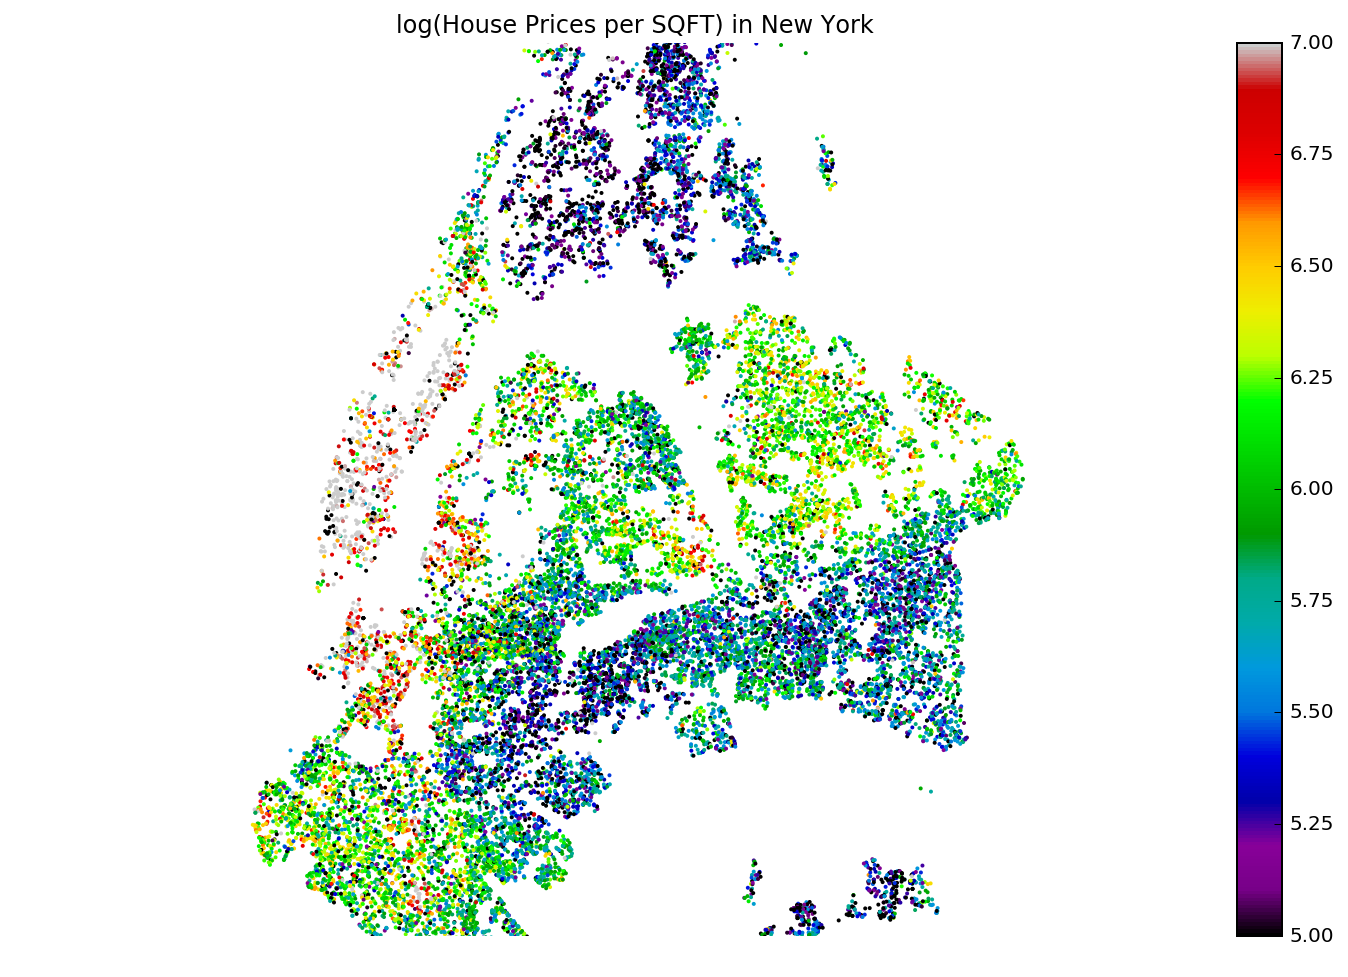

In [24]:
plt.scatter(sales_geocoded["XCoord"], sales_geocoded["YCoord"], 
    c=np.log(sales_geocoded["SALE PRICE"])-np.log(sales_geocoded["GROSS SQUARE FEET"]),
    cmap="spectral",
    edgecolor="None",
    vmin=5.0,
    vmax=7.0,
    s=4,
    )
plt.xlim(np.percentile(sales_geocoded["XCoord"].dropna(), [2,98]))
plt.ylim(np.percentile(sales_geocoded["YCoord"].dropna(), [2,98]))
plt.colorbar()
plt.title("log(House Prices per SQFT) in New York")
plt.axis("off")
plt.axes().set_aspect('equal', 'datalim')
;

## Missing locations

There's a large number of missing lots in the Pluto dataset.

In [25]:
sales.iloc[198:199,:]

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
198,Brooklyn,BATH BEACH,04 TAX CLASS 1 CONDOS,1A,6367,1010,NaN,R3,8659 BAY 16 STREET,3C,...,1.0,NaN,1.0,NaN,NaN,0.0,1.0,R3,552000.0,2016-03-16


In [26]:
sales_geocoded.iloc[127:128,:]

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,BoroughLong,ZipCode,Block,Lot,XCoord,YCoord,SchDistr
198,Brooklyn,BATH BEACH,04 TAX CLASS 1 CONDOS,1A,6367,1010,NaN,R3,8659 BAY 16 STREET,3C,...,R3,552000.0,2016-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
pluto[(pluto["Borough"]=="BK") & (pluto["Block"]=="6367")]

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,BoroughLong
188447,BK,6367,1,311,178.0,2000.0,20,43.0,11214,E243,...,22b,NaN,312 027,31906.0,NaN,0.000000e+00,NaN,1,16v1,Brooklyn
188448,BK,6367,6,311,178.0,2000.0,20,43.0,11214,E243,...,22b,NaN,312 027,31906.0,NaN,0.000000e+00,NaN,1,16v1,Brooklyn
188449,BK,6367,8,311,178.0,2000.0,20,43.0,11214,E243,...,22b,NaN,312 027,31906.0,NaN,0.000000e+00,NaN,1,16v1,Brooklyn
188450,BK,6367,10,311,178.0,2000.0,20,43.0,11214,E243,...,22b,NaN,312 027,31906.0,NaN,0.000000e+00,NaN,1,16v1,Brooklyn
188451,BK,6367,11,311,178.0,2000.0,20,43.0,11214,E243,...,22b,NaN,312 027,31906.0,NaN,0.000000e+00,NaN,1,16v1,Brooklyn
188452,BK,6367,12,311,178.0,2000.0,20,43.0,11214,E243,...,22b,NaN,312 027,31906.0,NaN,3.063670e+09,1/6/1998,1,16v1,Brooklyn
188453,BK,6367,13,311,178.0,2000.0,20,43.0,11214,E243,...,22b,NaN,312 027,31906.0,NaN,3.063670e+09,1/6/1998,1,16v1,Brooklyn
188454,BK,6367,20,311,178.0,2000.0,20,43.0,11214,E243,...,22b,NaN,312 027,31906.0,NaN,0.000000e+00,NaN,1,16v1,Brooklyn
188455,BK,6367,23,311,178.0,2000.0,20,43.0,11214,E243,...,22b,NaN,312 027,31906.0,NaN,0.000000e+00,NaN,1,16v1,Brooklyn
188456,BK,6367,24,311,178.0,2000.0,20,43.0,11214,E243,...,22b,NaN,312 027,31906.0,NaN,0.000000e+00,NaN,1,16v1,Brooklyn


In [28]:
missing_pluto = np.logical_not(np.isfinite(sales_geocoded["XCoord"]).values)
np.mean(missing_pluto)

0.29400686438440554

## Using google geocodes to fill in missing data

In [29]:
sales_geocoded_both=pd.merge(sales_geocoded, geocodes, how="left", 
    left_on=["BOROUGH","ADDRESS", "ZIP CODE"], 
    right_on=["BOROUGH","ADDRESS", "ZIP CODE"])

In [30]:
sales_geometry = gpd.GeoSeries([Point(xy) for xy in zip(sales_geocoded_both.lng, sales_geocoded_both.lat)], 
    crs={"proj":"latlong", "datum":"WGS84"})
sales_geometry=sales_geometry.to_crs(epsg=EPSG)

sales_geocoded_both["XCoordGGL"]=[p.x for p in sales_geometry]
sales_geocoded_both["YCoordGGL"]=[p.y for p in sales_geometry]

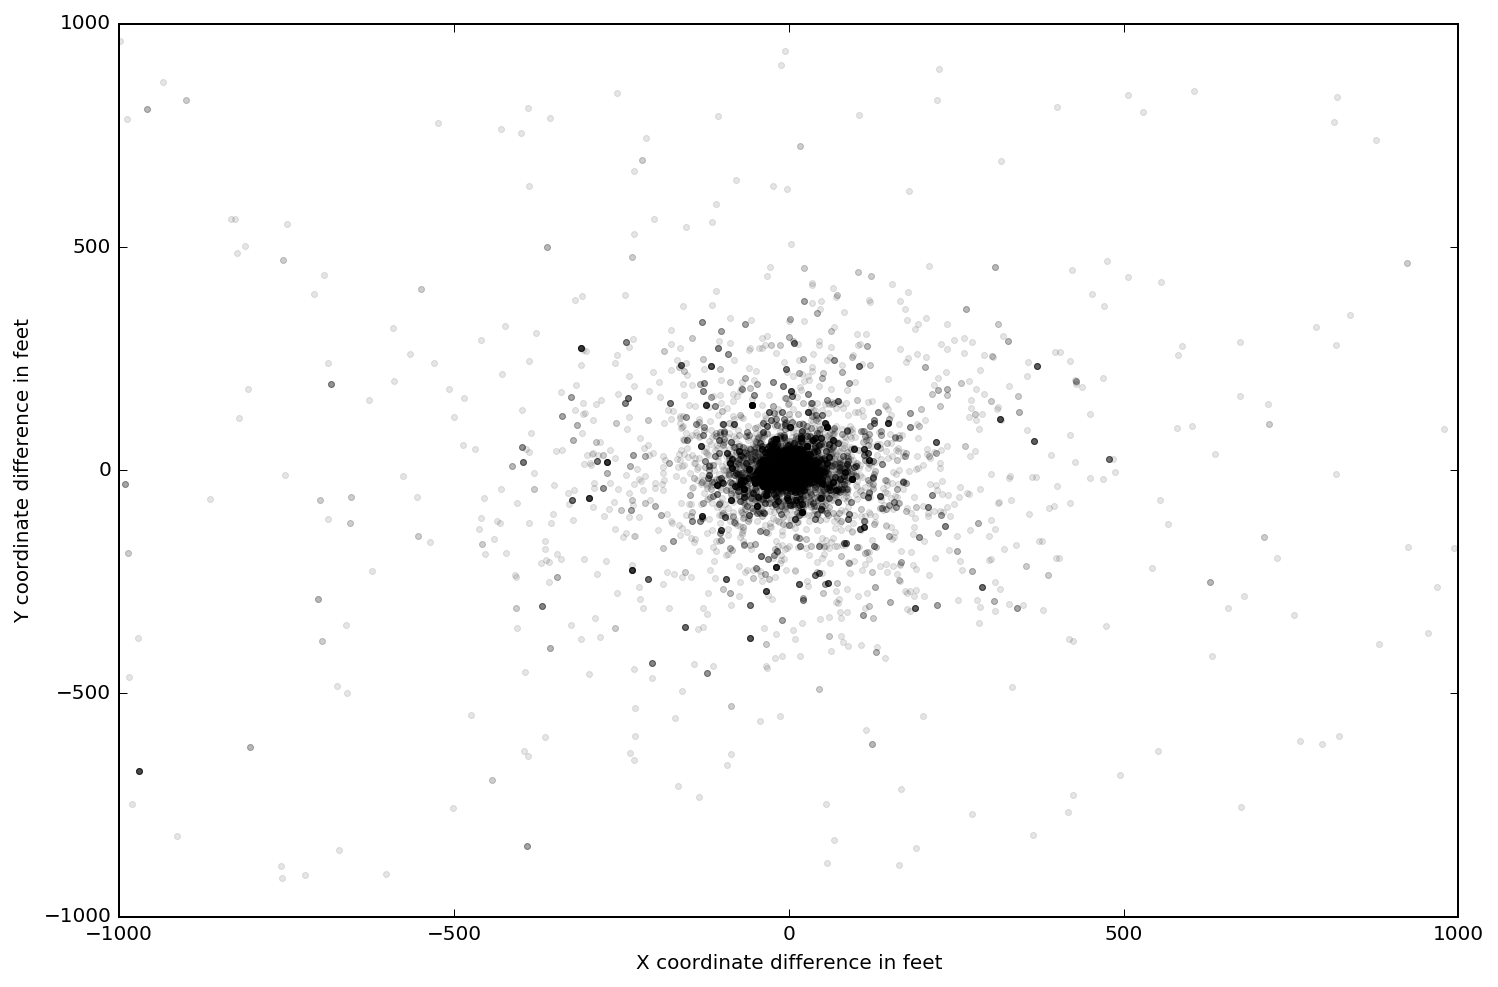

In [31]:
plt.plot(sales_geocoded_both["XCoordGGL"]-sales_geocoded_both["XCoord"], 
    sales_geocoded_both["YCoordGGL"]-sales_geocoded_both["YCoord"], 
    ".",
    color="black",
    alpha=0.1,
    )
plt.xlim(-1000, 1000)
plt.ylim(-1000,1000)
plt.xlabel("X coordinate difference in feet")
plt.ylabel("Y coordinate difference in feet")

(0, 200)

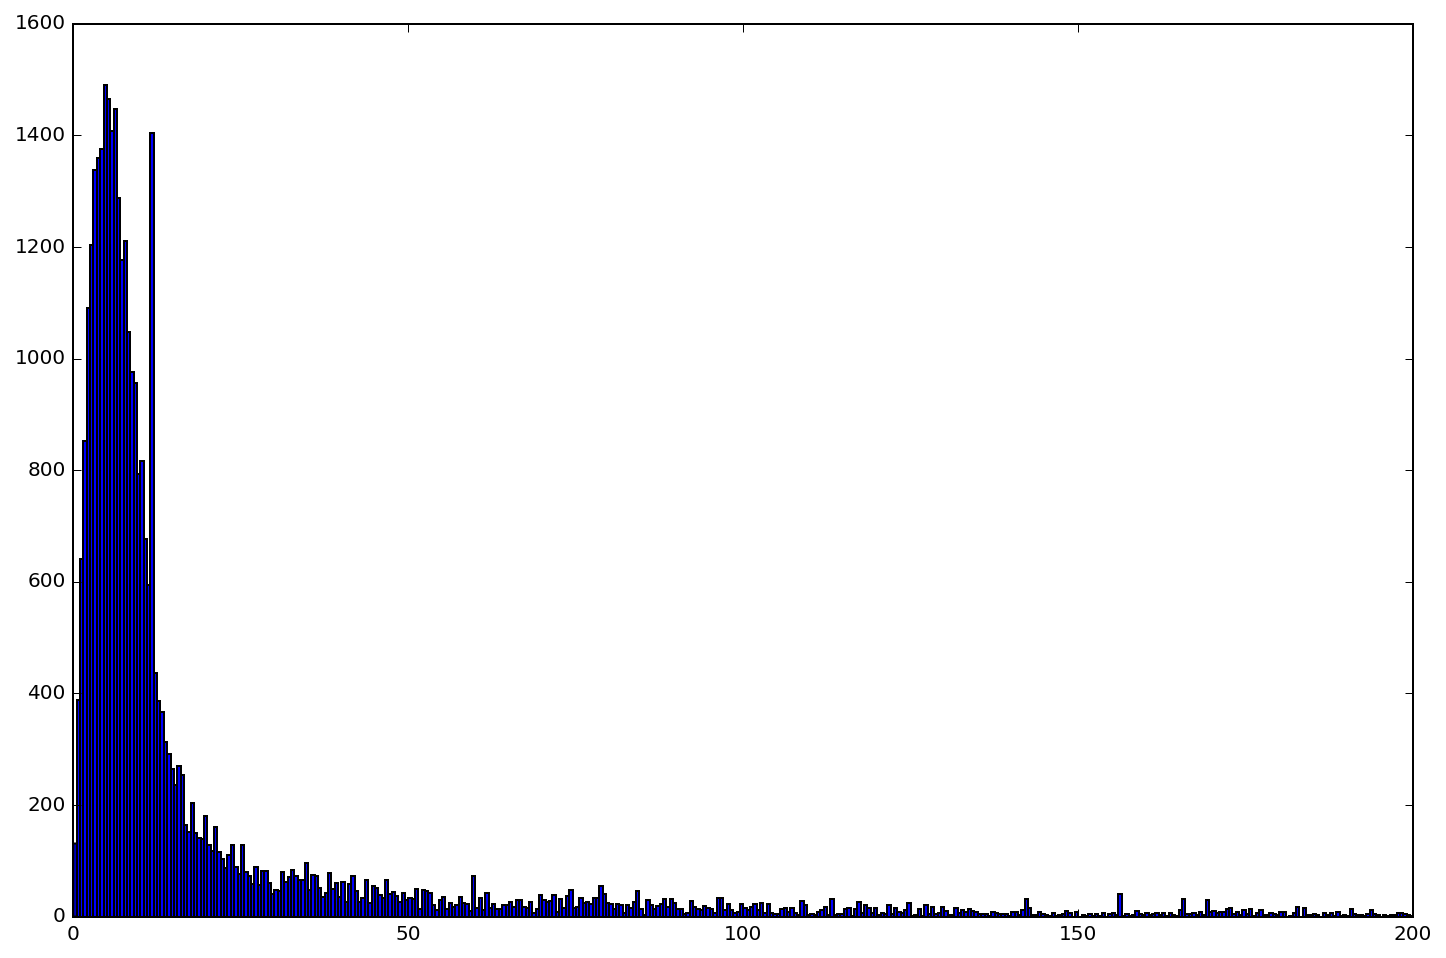

In [32]:
plt.hist(
    np.sqrt((sales_geocoded_both["XCoordGGL"]-sales_geocoded_both["XCoord"])**2
           +(sales_geocoded_both["YCoordGGL"]-sales_geocoded_both["YCoord"])**2).dropna(), bins=np.linspace(0,1000,2000))
plt.xlim(0,200)

For most houses, the Pluto and Google locations are in close agreement (distance is less than the typical size of a house), but there is a long tail of differences in locations.

In [33]:
sxy=sales_geocoded_both.ix[missing_pluto,["XCoord","YCoord"]]

In [34]:
sxy.values

array([[ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       ..., 
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan]])

In [35]:
sales_geocoded_both.ix[missing_pluto,"XCoord":"YCoord"] = \
    sales_geocoded_both.ix[missing_pluto,["XCoordGGL","YCoordGGL"]].values

In [36]:
sales_geocoded_both.iloc[127,:] # now has an XCoord and YCoord entry

BOROUGH                                         Brooklyn
NEIGHBORHOOD                                  BATH BEACH
BUILDING CLASS CATEGORY           04  TAX CLASS 1 CONDOS
TAX CLASS AT PRESENT                                  1A
BLOCK                                               6367
LOT                                                 1010
EASE-MENT                                            NaN
BUILDING CLASS AT PRESENT                             R3
ADDRESS                               8659 BAY 16 STREET
APARTMENT NUMBER                            3C          
ZIP CODE                                           11214
RESIDENTIAL UNITS                                      1
COMMERCIAL UNITS                                     NaN
TOTAL UNITS                                            1
LAND SQUARE FEET                                     NaN
GROSS SQUARE FEET                                    NaN
YEAR BUILT                                             0
TAX CLASS AT TIME OF SALE      

# Map Pluto

In [37]:
mappluto = pd.concat(gpd.read_file(
        "/%s_Dcp_Mappinglot.shp" % borough.upper(), 
        vfs="zip://NYC_data/MapPluto/%s_mappluto_16v1.zip" % borough,
        )
    for borough in ("bk", "bx", "mn", "qn", "si")
).to_crs(epsg=EPSG)

In [38]:
mappluto["LOT"] = mappluto["LOT"].astype(str)
mappluto["BLOCK"] = mappluto["BLOCK"].astype(str)

In [39]:
mappluto.dtypes

BLOCK          object
BORO           object
CREATED_BY     object
CREATED_DA     object
LAST_MODIF     object
LAST_MOD_1     object
LOT            object
Shape_Area    float64
Shape_Leng    float64
geometry       object
dtype: object

In [40]:
mappluto.centroid[:10]

0    POINT (1011844.498920937 175470.7359166084)
1     POINT (997322.7700837768 150561.956864769)
2     POINT (999378.876796666 150971.7307263138)
3    POINT (996082.0295694161 164413.6186448639)
4    POINT (997589.8726636649 150503.4281249041)
5    POINT (997576.0951158267 148792.0895236663)
6    POINT (1010237.473957577 162753.6013832643)
7    POINT (999192.7059490239 150462.3320375071)
8    POINT (997239.1001073407 149229.9473123791)
9    POINT (997250.8360363663 149145.5780501674)
dtype: object

In [41]:
mappluto.head()

,BLOCK,BORO,CREATED_BY,CREATED_DA,LAST_MODIF,LAST_MOD_1,LOT,Shape_Area,Shape_Leng,geometry
0,8170,3,None,1999-11-30,sj,2011-12-20,9999,8854.722594,421.447695,"POLYGON ((1011890.849900008 175413.3499999379,..."
1,8726,3,None,1999-11-30,sj,2011-09-20,9998,3822.953629,842.582019,"POLYGON ((997291.1199000039 150770.390099942, ..."
2,8746,3,None,1999-11-30,sj,2011-09-20,9999,630.516672,185.400824,"POLYGON ((999388.7899000049 150932.1800999386,..."
3,6746,3,None,1999-11-30,sj,2011-07-20,9999,1338.466924,156.959212,"POLYGON ((996071.3700000044 164395.239799951, ..."
4,8727,3,None,1999-11-30,sj,2011-09-20,9997,1453.959375,380.552112,"POLYGON ((997607.1599999981 150413.879999944, ..."


-> ended up using regular Pluto instead of Map Pluto

# School District Boundaries

In [42]:
nycdistrs=gpd.read_file("NYC_data/nysd_16c/nysd.shp").to_crs(epsg=EPSG)

In [43]:
nycdistrs.head()

,SchoolDist,Shape_Area,Shape_Leng,geometry
0,25,4.436314e+08,175816.081000,"POLYGON ((1033946.682983398 231157.9963988745,..."
1,20,2.427230e+08,95513.486010,"POLYGON ((977165.9473876945 176628.6171874552,..."
2,3,1.134879e+08,52071.976405,"POLYGON ((996235.5040283194 225859.7316283606,..."
3,4,5.262001e+07,52056.107857,(POLYGON ((1006028.597595215 231058.7958373566...
4,16,4.676362e+07,35848.904605,"POLYGON ((1002796.091003418 192779.0115966275,..."


''

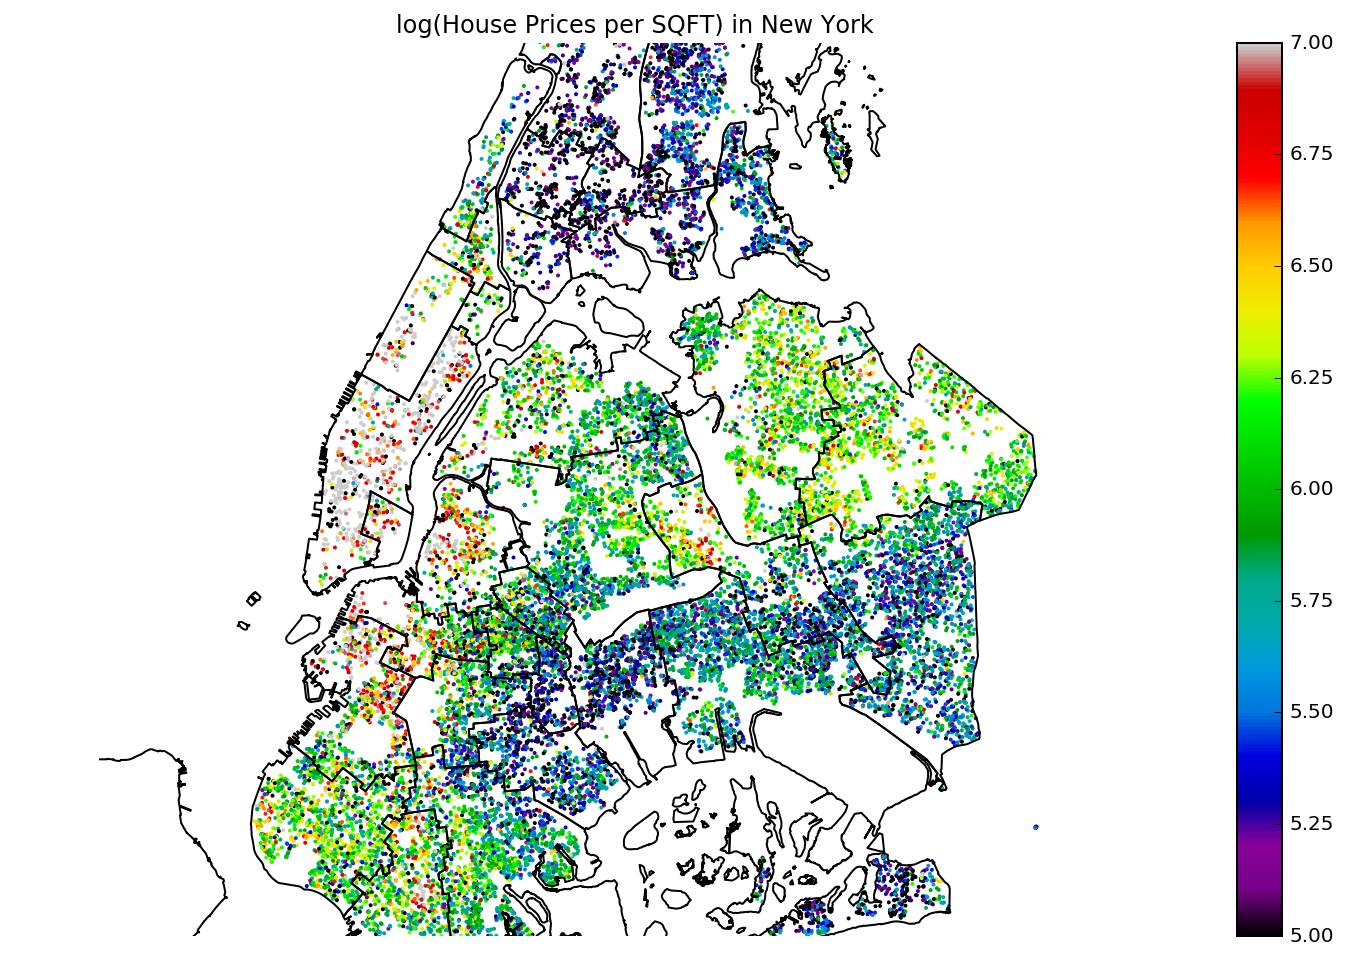

In [44]:
plt.scatter(sales_geocoded_both["XCoord"], sales_geocoded_both["YCoord"], 
    c=np.log(sales_geocoded_both["SALE PRICE"])-np.log(sales_geocoded_both["GROSS SQUARE FEET"]),
    cmap="spectral",
    edgecolor="None",
    vmin=5.0,
    vmax=7.0,
    s=4,
    )
plt.axes().set_aspect('equal', 'datalim')
plt.axis("off")
plot_dataframe(nycdistrs, color="None", figsize=(24.0, 16.0), ax=plt.gca())
plt.xlim(np.percentile(sales_geocoded_both["XCoord"].dropna(), [2,98]))
plt.ylim(np.percentile(sales_geocoded_both["YCoord"].dropna(), [2,98]))
plt.colorbar()
plt.title("log(House Prices per SQFT) in New York")
;

# Counties

In [45]:
counties=gpd.read_file("../national_data/cb_2015_us_county_500k/cb_2015_us_county_500k.shp").to_crs(epsg=EPSG)

In [46]:
counties.head()

,AFFGEOID,ALAND,AWATER,COUNTYFP,COUNTYNS,GEOID,LSAD,NAME,STATEFP,geometry
0,0500000US01005,2.291821e+09,50864677.0,005,00161528,01005,06,Barbour,01,POLYGON ((-2707415.855703067 -2877716.26454153...
1,0500000US01023,2.365955e+09,19059247.0,023,00161537,01023,06,Choctaw,01,POLYGON ((-3540074.513784979 -2649887.10033756...
2,0500000US01035,2.201896e+09,6643480.0,035,00161543,01035,06,Conecuh,01,POLYGON ((-3251159.132570515 -2931142.43909308...
3,0500000US01051,1.601877e+09,99850740.0,051,00161551,01051,06,Elmore,01,POLYGON ((-2856337.972736434 -2436895.58067867...
4,0500000US01065,1.667805e+09,32525874.0,065,00161558,01065,06,Hale,01,POLYGON ((-3302901.948525312 -2364989.20114470...


# Attach school district to each sale

In [47]:
def get_ind(zones, point):
    ind=np.where(zones.contains(point))[0]
    if len(ind)==0:
        return None
    elif len(ind)>1:
        return None#np.argmin(zones.iloc[ind].area)
    return ind[0]

In [48]:
def get_ind_2(zones, hulls, point):
    possible = np.where(hulls.contains(point))[0]
    ind = get_ind(zones[possible], point)
    if ind is not None:
        return possible[ind]
    else:
        return ind

In [49]:
%time get_ind(nycdistrs.geometry, sales_geometry[4000])

CPU times: user 17 ms, sys: 804 µs, total: 17.8 ms
Wall time: 17 ms


8

In [50]:
ch = nycdistrs.geometry.convex_hull
%time get_ind_2(nycdistrs.geometry, ch, sales_geometry[4000])

CPU times: user 2.21 ms, sys: 58 µs, total: 2.27 ms
Wall time: 2.35 ms


8

In [51]:
sales_geometry_both = gpd.GeoSeries([Point(xy) for xy in zip(sales_geocoded_both.XCoord, sales_geocoded_both.YCoord)], 
    crs=sales_geometry.crs)

Check that `get_ind` and `get_ind_2` return the same output on the first 1000 rows.

In [52]:
%time _idistr=[get_ind(nycdistrs.geometry, house) for house in sales_geometry_both[:1000]]

CPU times: user 2.6 s, sys: 4.77 ms, total: 2.6 s
Wall time: 2.6 s


In [53]:
ch = nycdistrs.geometry.convex_hull
%time _idistr2=[get_ind_2(nycdistrs.geometry, ch, house) for house in sales_geometry_both[:1000]]

CPU times: user 1.71 s, sys: 3.65 ms, total: 1.71 s
Wall time: 1.71 s


In [54]:
assert _idistr==_idistr2, "not getting the same districts"

In [55]:
idistr=[get_ind_2(nycdistrs.geometry, ch, house) for house in sales_geometry_both]

In [56]:
sum([i is None for i in idistr]) # hopefully low

41

In [57]:
has_schdistr = np.array([i is not None for i in idistr]) # get_ind() successfully gave us a school district

In [58]:
# rate of success obtaining a school district
np.mean(has_schdistr)

0.99927835958813693

In [59]:
# `hasboth` is the (boolean) indices of the rows that have X-Y coordinates
# from Pluto, and have been assigned a 
# school district by the `get_ind()` function.
# So these are the rows where we can compare school districts between
# the two methods.
hasboth = np.logical_and(has_schdistr, np.logical_not(missing_pluto))
pluto_schdistr = sales_geocoded_both.ix[hasboth,"SchDistr"]
my_schdistr = nycdistrs.SchoolDist.values[np.array(idistr)[hasboth].astype(int)].astype(str)
agree= pluto_schdistr == my_schdistr
# Now we compute the proportion of sales where the school district
# from Pluto agrees with the school district from get_ind()
np.mean(agree) # hopefully close to 1

0.99912729086148855

Default to the Pluto school district. Only using our school district if there isn't one already.

In [60]:
use_my_schdistr = has_schdistr&missing_pluto
my_schdistr = nycdistrs.SchoolDist.values[np.array(idistr)[use_my_schdistr].astype(int)].astype(str)
sales_geocoded_both.ix[use_my_schdistr, "SchDistr"] = my_schdistr

Let's see which school districts saw the most sales:

In [61]:
sales_geocoded_both["SchDistr"].value_counts()

2     13982
25     3096
27     2846
3      2779
28     2778
22     2437
24     2352
29     2292
26     2282
30     2193
20     1906
13     1839
11     1769
15     1762
21     1671
14     1327
10     1271
17     1008
8       985
19      976
18      744
6       719
16      616
32      603
5       503
1       502
12      399
9       383
23      368
7       214
4       189
31        9
Name: SchDistr, dtype: int64

# Borders

In [62]:
ndistr = nycdistrs.shape[0]
distr1_ls=[]
distr2_ls=[]
sentinels_ls=[]
borders_ls=[]

for i,j in itertools.combinations(range(ndistr),2):
    di = nycdistrs.geometry.values[i]
    dj = nycdistrs.geometry.values[j]
    distr_i = nycdistrs.SchoolDist.values[i]
    distr_j = nycdistrs.SchoolDist.values[j]
    border = di.boundary.intersection(dj.buffer(100))
#     if border.geom_type=='MultiPolygon':
#         lengths = [g.length for g in border.geoms]
#         border = border.geoms[np.argmax(lengths)]
    if not border.length:
        continue
#     assert isinstance(border, MultiLineString)
    if isinstance(border, MultiLineString):
        merged_border = shapely.ops.linemerge(border)
    else:
        merged_border = border
    sentinels = MultiPoint([merged_border.interpolate(x, normalized=True) for x in np.linspace(0,1.0,100)])
    sentinels_ls.append(sentinels)
    sentinels_ls.append(sentinels)
    borders_ls.append(merged_border)
    borders_ls.append(merged_border)
    distr1_ls.append(distr_i)
    distr1_ls.append(distr_j)
    distr2_ls.append(distr_j)
    distr2_ls.append(distr_i)

In [63]:
i=28
j=29
di = nycdistrs.geometry.values[i]
dj = nycdistrs.geometry.values[j]
distr_i = nycdistrs.SchoolDist.values[i]
distr_j = nycdistrs.SchoolDist.values[j]
border = di.boundary.intersection(dj.buffer(20))

In [64]:
type(border)

shapely.geometry.multilinestring.MultiLineString

In [65]:
merged_border=shapely.ops.linemerge(border)

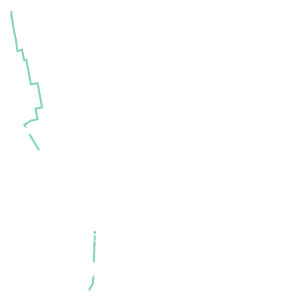

In [66]:
merged_border

In [67]:
merged_border[4].length

57.74401609714992

In [68]:
len(merged_border)

8

In [69]:
sentinels = MultiPoint([merged_border.interpolate(x, normalized=True) for x in np.linspace(0,1.0,100)])

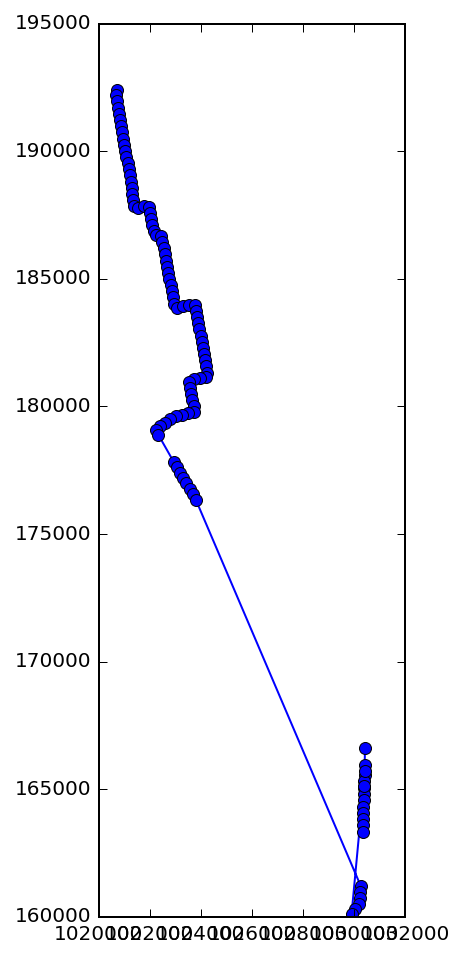

In [70]:
plt.plot([p.x for p in sentinels.geoms], [p.y for p in sentinels.geoms], "-o")
plt.gca().set_aspect("equal")

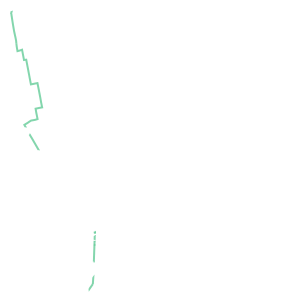

In [71]:
border

In [72]:
len(border.geoms)

12

In [73]:
borders = gpd.GeoDataFrame({"SchoolDistrict1":distr1_ls, "SchoolDistrict2": distr2_ls, "geometry": borders_ls})
sentinels = gpd.GeoDataFrame({"SchoolDistrict1":distr1_ls, "SchoolDistrict2": distr2_ls, "geometry": sentinels_ls})

# Checking district 1 data is in district 1

In [74]:
d1 = sales_geocoded_both.ix[sales_geocoded_both["SchDistr"]=="1",:]

(197000.0, 207000.0)

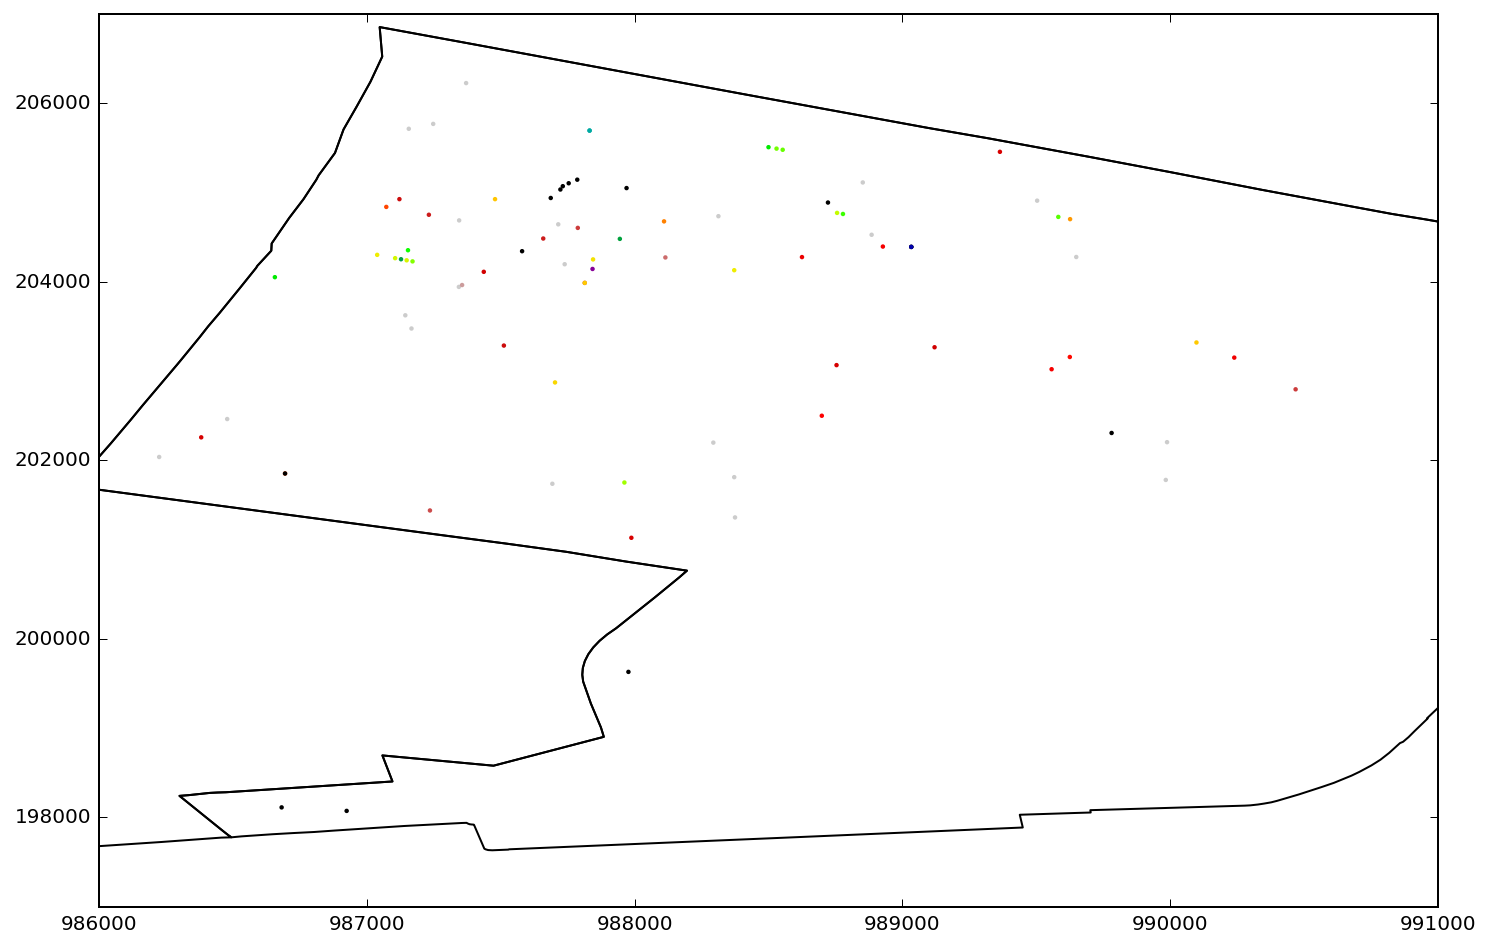

In [75]:
plt.scatter(d1["XCoord"], d1["YCoord"], 
    c=np.log(d1["SALE PRICE"])-np.log(d1["GROSS SQUARE FEET"]),
    cmap="spectral",
    edgecolor="None",
    vmin=5.0,
    vmax=7.0,
    s=5,
    )
_xlim = plt.xlim()
_ylim = plt.ylim()
plot_dataframe(nycdistrs, color="None", figsize=(24.0, 16.0), ax=plt.gca())
plt.xlim(_xlim)
plt.ylim(_ylim)

# Grid for extrapolation

In [76]:
import csv
for i in range(len(nycdistrs)):
    di = nycdistrs.geometry.values[i]
    schdistr = "%02d" % nycdistrs.SchoolDist.values[i]
    ngrid=200
    xgrid = np.linspace(di.bounds[0], di.bounds[2], ngrid)
    ygrid = np.linspace(di.bounds[1], di.bounds[3], ngrid)
    xygrid = np.meshgrid(xgrid, ygrid)
    points = [Point(xy) for xy in zip(
        np.reshape(xygrid[0], ngrid**2), 
        np.reshape(xygrid[1], ngrid**2))]
    points_inside = di.intersection(MultiPoint(points))
    points_inside = [[p.x,p.y] for p in  points_inside.geoms]
    with open("NYC_data/processed/SchoolDistrict_grids/SchoolDistrict_grid_%s.csv" % schdistr, "w") as f:
        csvwriter = csv.writer(f)
        csvwriter.writerows(points_inside)

# Data Export

In [77]:
sales_geocoded_both.iloc[0]

BOROUGH                                           Brooklyn
NEIGHBORHOOD                                    BATH BEACH
BUILDING CLASS CATEGORY           01  ONE FAMILY DWELLINGS
TAX CLASS AT PRESENT                                     1
BLOCK                                                 6361
LOT                                                     11
EASE-MENT                                              NaN
BUILDING CLASS AT PRESENT                               A5
ADDRESS                               71 BAY 10TH   STREET
APARTMENT NUMBER                                       NaN
ZIP CODE                                             11228
RESIDENTIAL UNITS                                        1
COMMERCIAL UNITS                                       NaN
TOTAL UNITS                                              1
LAND SQUARE FEET                                      2900
GROSS SQUARE FEET                                     1660
YEAR BUILT                                            19

In [78]:
sales_geocoded_both[[
    "BOROUGH",
    "BUILDING CLASS CATEGORY", 
    "BUILDING CLASS AT TIME OF SALE", 
    "TAX CLASS AT TIME OF SALE", 
    "TAX CLASS AT PRESENT", 
    "ADDRESS",
    "BUILDING CLASS AT PRESENT",
    "ZIP CODE",
    "XCoord",
    "YCoord",
    "SchDistr",
    "NEIGHBORHOOD",
    "GROSS SQUARE FEET",
    "SALE PRICE",
    "SALE DATE",
    "LAND SQUARE FEET"]].to_csv("NYC_data/processed/NYC_sales.csv")

In [79]:
sentinels.to_file('NYC_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.shp', driver='ESRI Shapefile')

In [80]:
with open("NYC_data/processed/SchoolDistrict_borders/SchoolDistrict_borders.json", "w") as f:
    f.write(borders.to_json())

In [81]:
with open("NYC_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.json", "w") as f:
    f.write(sentinels.to_json())

In [82]:
import matplotlib.patheffects as path_effects

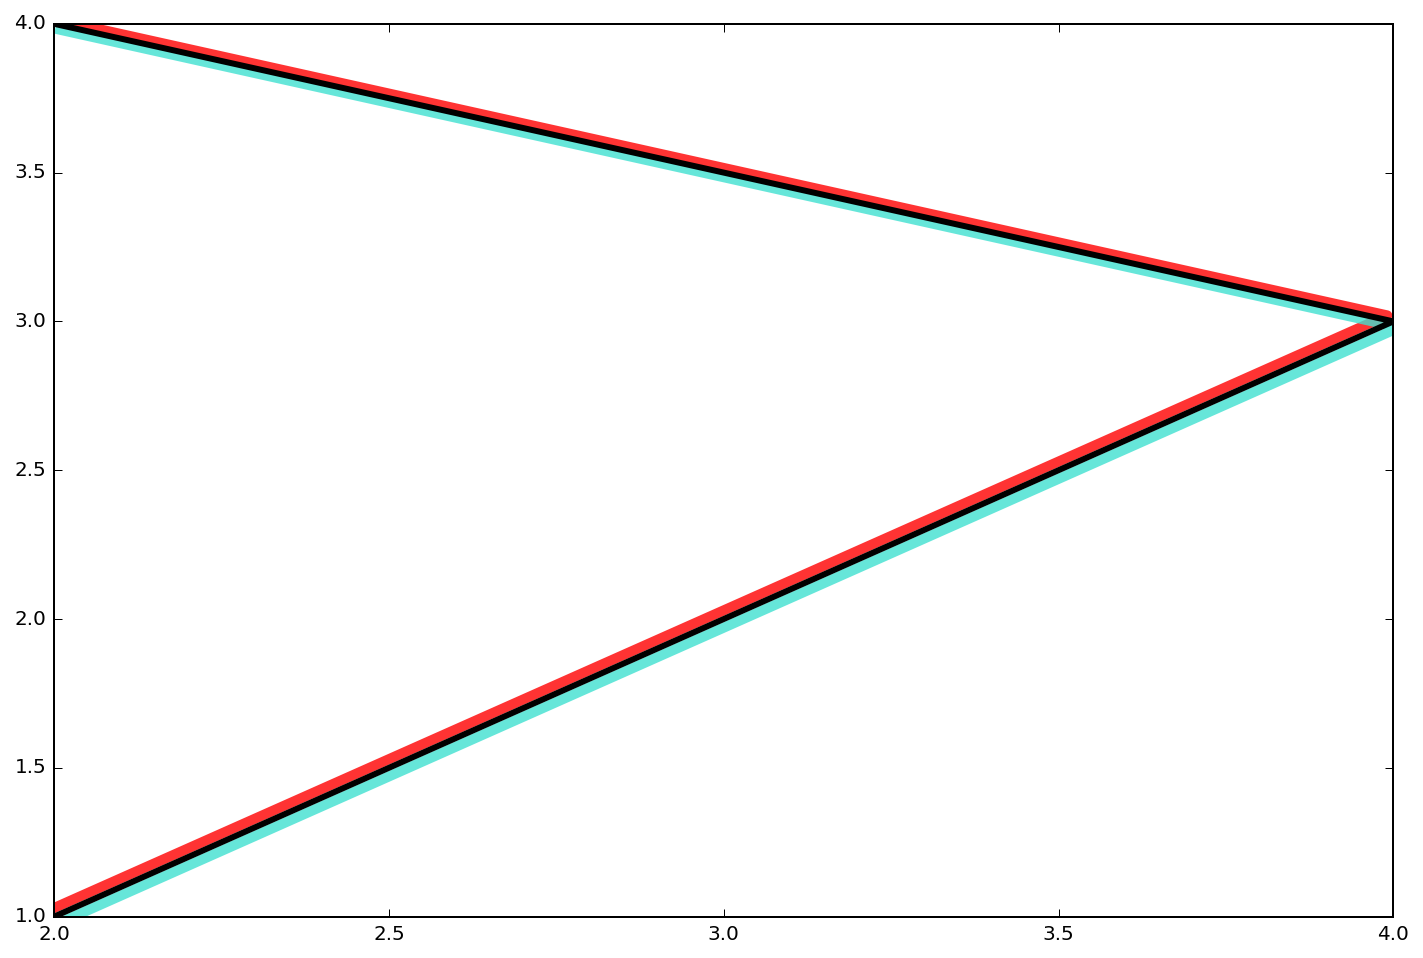

In [83]:
plt.plot([2,3,4,2], [1,2,3,4], linewidth=3, color="black", path_effects=[
    path_effects.SimpleLineShadow(shadow_color="red", linewidth=5, alpha=0.8, offset=(-3,3)),
    path_effects.SimpleLineShadow(shadow_color="turquoise", linewidth=5, alpha=0.8, offset=(3,-3)),
    path_effects.Normal()])